This is a Poisson equation with Dirichlet boundary conditions solved with a PINN model using the DeepXDE library.

<br>\begin{equation}
−Δu = π^2sin(πx) \hspace{1cm} x∈[-1,1] 
\end{equation}

<br>

\begin{equation}
u(-1) = 0  \hspace{1cm} u(1) = 0
\end{equation}

Test losses after 6000 epochs are approximately:

*In accordance to y output:* **8.07e-05**

*In accordance to boundary conditions:* **2.35e-06**

*In accordance to the known solution:* **1.40e-03**

In [ ]:
# Importing libraries
  
!pip install deepxde
import deepxde as dde
import numpy as np

Using backend: tensorflow.compat.v1



Instructions for updating:
non-resource variables are not supported in the long term



In [ ]:
# Define computational geometry

geom = dde.geometry.Interval(-1, 1)

In [ ]:
# Define the differential equation

def ode(x, y):
  dy_xx = dde.grad.hessian(y, x)
  return dy_xx + np.pi ** 2 * tf.sin(np.pi * x)

In [ ]:
# Define boundary conditions

def boundary(_, on_boundary):
  return on_boundary

bc = dde.icbc.DirichletBC(geom, lambda x: 0, boundary)

In [ ]:
# Define known solution

def sol(x):
  return np.sin(np.pi*x)

In [ ]:
# Accumulate all the data for the model

data = dde.data.PDE(geom, ode, [bc], num_domain=200, num_boundary=2, solution=sol, num_test=100)

/usr/local/lib/python3.7/dist-packages/skopt/sampler/sobol.py:250: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+202=202. 
  total_n_samples))


In [ ]:
# Create the neural network

layer_size = [1] + [60] * 2 + [1]
activation = "tanh"
initializer = "Glorot uniform"

net = dde.nn.FNN(layer_size, activation, initializer)

In [ ]:
# Build and train the model

model = dde.Model(data, net)
model.compile("adam", lr=0.001, metrics=["l2 relative error"])

losshistory, train_state = model.train(epochs=6000)

Compiling model...
Building feed-forward neural network...
'build' took 0.098741 s



/usr/local/lib/python3.7/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:110: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  kernel_constraint=self.kernel_constraint,
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:261: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)


'compile' took 0.978097 s

Initializing variables...
Training model...

Step      Train loss              Test loss               Test metric   
0         [4.82e+01, 2.69e-01]    [4.83e+01, 2.69e-01]    [7.16e-01]    
1000      [2.39e-04, 1.25e-08]    [1.71e-04, 1.25e-08]    [1.37e-04]    
2000      [5.71e-05, 1.54e-09]    [3.75e-05, 1.54e-09]    [6.26e-05]    
3000      [1.60e-05, 3.31e-11]    [9.93e-06, 3.31e-11]    [2.26e-05]    
4000      [4.93e-04, 2.30e-05]    [4.95e-04, 2.30e-05]    [3.93e-03]    
5000      [2.02e-05, 4.55e-07]    [1.66e-05, 4.55e-07]    [5.77e-04]    
6000      [8.06e-05, 2.35e-06]    [8.07e-05, 2.35e-06]    [1.40e-03]    

Best model at step 3000:
  train loss: 1.60e-05
  test loss: 9.93e-06
  test metric: [2.26e-05]

'train' took 15.316566 s



Saving loss history to /content/loss.dat ...
Saving training data to /content/train.dat ...
Saving test data to /content/test.dat ...


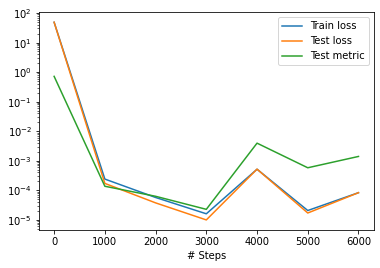

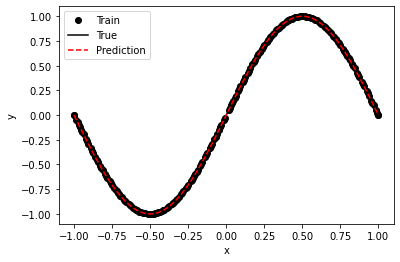

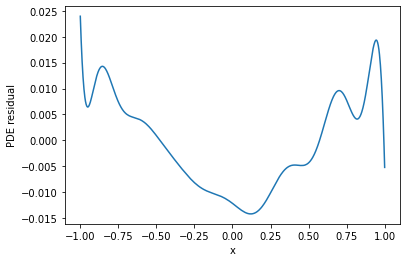

In [ ]:
# Generating plots of the results.

import matplotlib.pyplot as plt

dde.saveplot(losshistory, train_state, issave=True, isplot=True)
x = geom.uniform_points(1000, True)
y = model.predict(x, operator=ode)

plt.figure()
plt.plot(x, y)
plt.xlabel("x")
plt.ylabel("PDE residual")
plt.show()